## Publishing rate analyzer [Fake data]

This notebook is a proof of concept for the real data analysis. It uses generated data in place of the real data used in the 2017 study: [The Research Productivity of New PhDs in Economics: The Surprisingly High Non-success of the Successful](https://www.aeaweb.org/articles?id=10.1257/jep.28.3.205).

The proof of concept is a mental baseline for myself before doing the real analysis.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import theano.tensor as tt
import pymc3 as pm
import arviz as az

# import warnings
# warnings.filterwarnings('ignore')

sns.set_palette("husl")

In [7]:
fake_data = pd.read_csv("fake_data/fake_data.csv")
fake_data.head()

In [25]:
with pm.Model() as fake_model:
    shape = pm.Uniform("shape", lower=0, upper=2)
    scale = pm.HalfNormal("scale", sigma=1)
    gamma = pm.Gamma("liklihood", alpha = shape, beta = scale, observed = fake_data.AERPub)
    
    inf_data = pm.sample(draws = 2000, tune=1000, cores=4, chains=4, step=pm.NUTS(), return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scale, shape]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


In [15]:
print("Free variables: ", fake_model.free_RVs)
print("Observed variables: ", fake_model.observed_RVs)

Free variables:  [shape_interval__, scale_log__]
Observed variables:  [liklihood]


In [26]:
inf_data.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    shape    (chain, draw) float64 0.196 0.2023 0.2 ... 0.1974 0.2023 0.1983
    scale    (chain, draw) float64 0.3295 0.3236 0.3258 ... 0.3282 0.334 0.3249
Attributes:
    created_at:                 2020-09-01T15:32:32.094915
    arviz_version:              0.9.0
    inference_library:          pymc3
    inference_library_version:  3.9.3
    sampling_time:              37.07358002662659
    tuning_steps:               1000

In [31]:
inf_data.posterior.shape

<xarray.DataArray 'shape' (chain: 4, draw: 2000)>
array([[0.19601972, 0.20230491, 0.19998842, ..., 0.19862789, 0.19862789,
        0.19902636],
       [0.20033544, 0.19866781, 0.19942003, ..., 0.19731584, 0.20052717,
        0.20032672],
       [0.20138289, 0.20138289, 0.20055072, ..., 0.19862014, 0.19858261,
        0.19858261],
       [0.20165379, 0.20014833, 0.19955799, ..., 0.19736649, 0.20229855,
        0.1982529 ]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

In [33]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
shape,0.20,0.002,0.196,0.204,0.0,0.0,5225.0,5222.0,5229.0,4672.0,1.0
scale,0.33,0.007,0.316,0.344,0.0,0.0,5371.0,5370.0,5361.0,4845.0,1.0


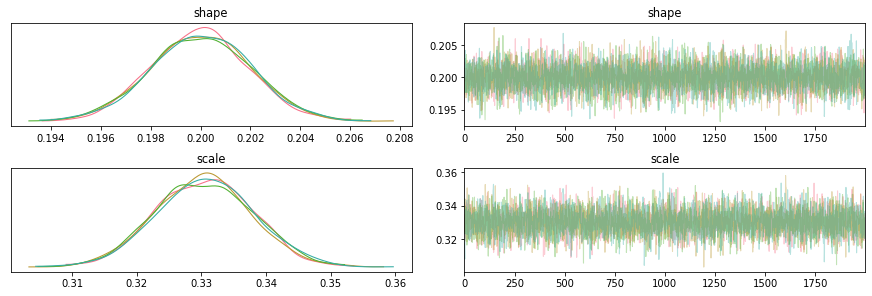

In [34]:
# The shape is correct, but the scale may be off here. Confirm.
az.plot_trace(inf_data);

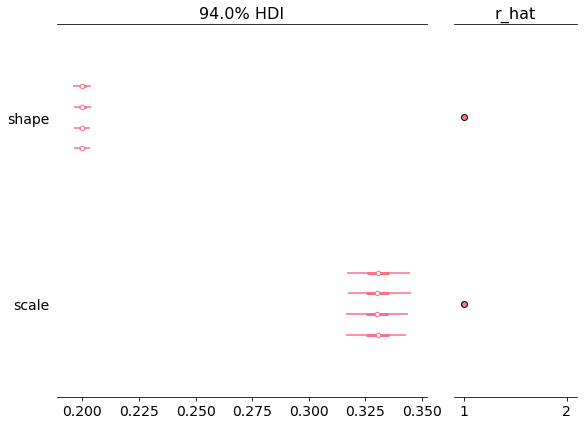

In [36]:
az.plot_forest(inf_data, r_hat=True);

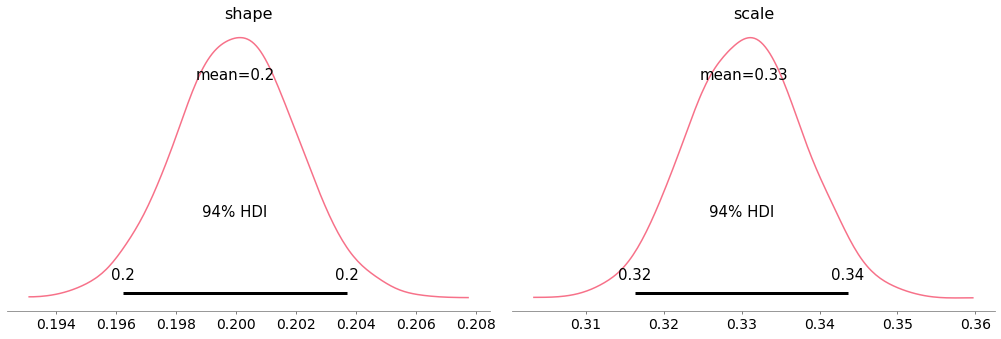

In [38]:
az.plot_posterior(inf_data);

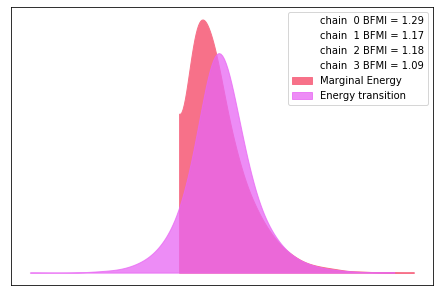

In [41]:
# TODO - look up energy plot interpretation
az.plot_energy(inf_data);

In [ ]:
# Todo tomorrow, go through each plot and explain the outputs.